## Twitter Sentiment Analysis


In this project, a dictionary-based sentiment analysis approach was applied to Twitter data. The main idea of this method is to determine the sentiment of a text by comparing its words against predefined sentiment lexicons rather than training a machine learning model.

First, the tweets were preprocessed to improve analysis quality. This included converting text to lowercase, removing punctuation, URLs, special characters, and stopwords. These steps reduce noise and ensure that only meaningful words contribute to sentiment detection.

Next, sentiment was computed using sentiment dictionaries that assign polarity scores (positive, negative, or neutral) to words. For each tweet, sentiment scores were calculated by summing the scores of individual words found in the lexicon.

If the total score was positive, the tweet was classified as positive

If negative, as negative

If zero, as neutral

Finally, the overall sentiment distribution was analyzed and visualized to understand public opinion trends within the dataset.

This dictionary-based approach is simple, interpretable, and computationally efficient, making it suitable for baseline sentiment analysis and exploratory studies.

In [1]:
## Load Library

import numpy as np
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy

from nltk.sentiment.vader import SentimentIntensityAnalyzer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.4 MB/s eta 0:00:00


In [3]:
import emoji

## Load & Inspect Data

##### Data sourced:https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/K4XSYC

In [4]:
## Load data

twitter = pd.read_csv(
    "senator_twitter_May-Oct.csv",
    encoding="latin1"
)

print(twitter.head())

   Unnamed: 0.1  Unnamed: 0             tweet_id                 time  \
0          4014          37  1322145371108331520  2020-10-30 11:56:35   
1          4015          38  1321926867696390144  2020-10-29 21:28:20   
2          4016          39  1321906471244845061  2020-10-29 20:07:17   
3          4017          40  1321517100398268416  2020-10-28 18:20:03   
4          4018          41  1321478513988423680  2020-10-28 15:46:44   

                                                text  replies  retweets  \
0  More jobs. More investment. More economic oppo...       40        24   
1  Marty and I are excited to be back on the camp...       46        26   
2  ICYMI: Gov. Kemp announces 46 people snared in...       24        30   
3  I promised that Georgia would stop and dismant...       29        37   
4  Now or on November 3rd, vote for the political...       88        35   

   likes       from_user                                       from_content  \
0    143             NaN       

## Data Preprocessing(EDA purpose)

In [5]:
## Text column cleaning(whitespace nomalization, remove URL, lowercase)

twitter = twitter.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')
twitter['text'] = twitter['text'].astype(str)

def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

twitter['clean_text'] = twitter['text'].apply(clean_tweet)


print(twitter[['text', 'clean_text']].head())
print(twitter['clean_text'].str.len().describe())

                                                text  \
0  More jobs. More investment. More economic oppo...   
1  Marty and I are excited to be back on the camp...   
2  ICYMI: Gov. Kemp announces 46 people snared in...   
3  I promised that Georgia would stop and dismant...   
4  Now or on November 3rd, vote for the political...   

                                          clean_text  
0  more jobs. more investment. more economic oppo...  
1  marty and i are excited to be back on the camp...  
2  icymi: gov. kemp announces 46 people snared in...  
3  i promised that georgia would stop and dismant...  
4  now or on november 3rd, vote for the political...  
count    30490.000000
mean       188.192260
std         73.798105
min          0.000000
25%        135.000000
50%        207.000000
75%        249.000000
max        363.000000
Name: clean_text, dtype: float64


In [6]:
## Standardize metadata

twitter['party_std'] = (
    twitter['party']
    .str.strip()
    .str.lower()
    .map({'democrat': 'Dem', 'republican': 'Rep'})
    .fillna('Other')
)

twitter['state'] = twitter['state'].str.upper()
twitter['time'] = pd.to_datetime(twitter['time'])
twitter['year'] = twitter['time'].dt.year
twitter['month'] = twitter['time'].dt.month
twitter['quarter'] = twitter['time'].dt.quarter

## Exploratory Analysis


In [7]:
## Tweets count

tweets_by_senator = twitter.groupby('twitter_id').size()
tweets_by_party = twitter.groupby('party_std').size()
tweets_by_year = twitter.groupby('year').size()
tweets_by_state = twitter.groupby('state').size()

In [8]:
## Compare activity levels

activity = (
    twitter.groupby('twitter_id')
    .size()
    .sort_values(ascending=False)
)

most_active = activity.head(10)
least_active = activity.tail(10)

print(most_active)
print(least_active)


twitter_id
GovMurphy         3342
GovMikeDeWine     2252
GovParsonMO       1685
MayorBowser       1351
dougducey         1323
GovPritzker       1226
GovAndyBeshear    1148
LouisianaGov      1142
GovNedLamont       963
NC_Governor        950
dtype: int64
twitter_id
GovernorLittle    246
GovWhitmer        232
GovDunleavy       219
henrymcmaster     182
GovernorGordon    145
GovofCO           122
LarryHogan        108
GovJanetMills      94
KimReynoldsIA      77
GinaRaimondo        3
dtype: int64


In [9]:
## Tweet length

twitter['tweet_length'] = twitter['clean_text'].str.len()

avg_length_by_party = twitter.groupby('party_std')['tweet_length'].mean()
print(avg_length_by_party)

party_std
Other    191.881807
Rep      183.021895
Name: tweet_length, dtype: float64


In [10]:
## Hashtag count

twitter['hashtag_count'] = twitter['text'].str.count(r'#\w+')

avg_hashtag_by_party = twitter.groupby('party_std')['hashtag_count'].mean()
print(avg_hashtag_by_party)

party_std
Other    0.463890
Rep      0.591951
Name: hashtag_count, dtype: float64


## EDA visualization

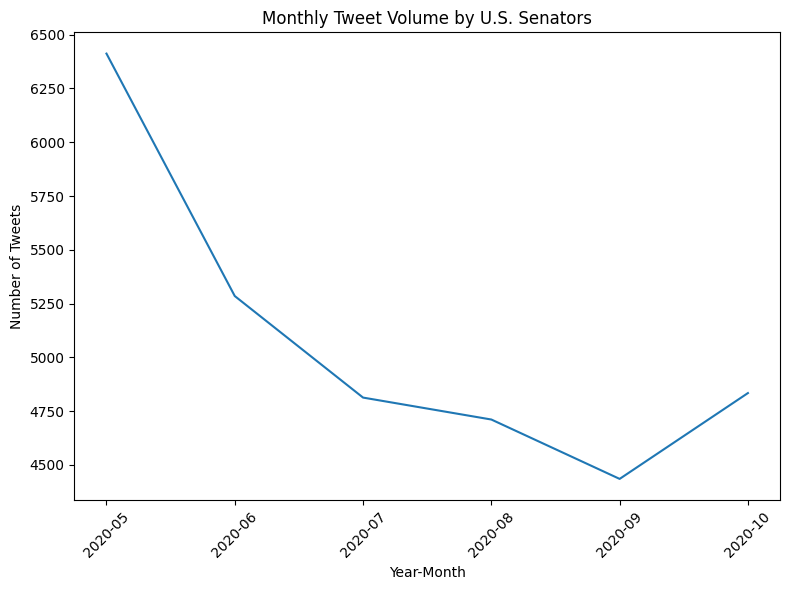

In [11]:
# Monthly Tweet Volume（Year–Month）

twitter['year_month'] = twitter['time'].dt.to_period('M').astype(str)

monthly_volume = (
    twitter
    .groupby('year_month')
    .size()
    .reset_index(name='tweet_count')
)
plt.figure(figsize=(8, 6))
plt.plot(monthly_volume['year_month'], monthly_volume['tweet_count'])
plt.xticks(rotation=45)
plt.title('Monthly Tweet Volume by U.S. Senators')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

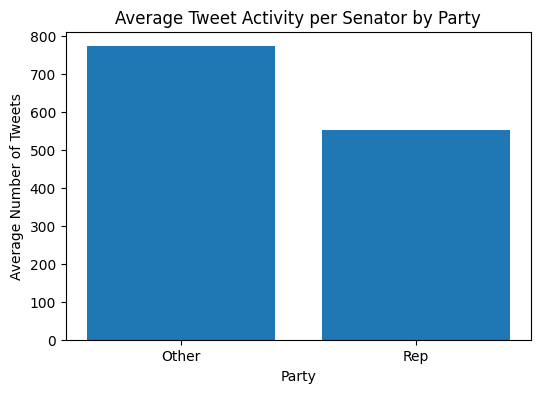

In [12]:
# Activity Difference: Dems vs Republicans

party_activity = (
    twitter
    .groupby(['party_std', 'twitter_id'])
    .size()
    .groupby('party_std')
    .mean()
    .reset_index(name='avg_tweets_per_senator')
)
plt.figure(figsize=(6, 4))
plt.bar(
    party_activity['party_std'],
    party_activity['avg_tweets_per_senator']
)
plt.title('Average Tweet Activity per Senator by Party')
plt.xlabel('Party')
plt.ylabel('Average Number of Tweets')
plt.show()


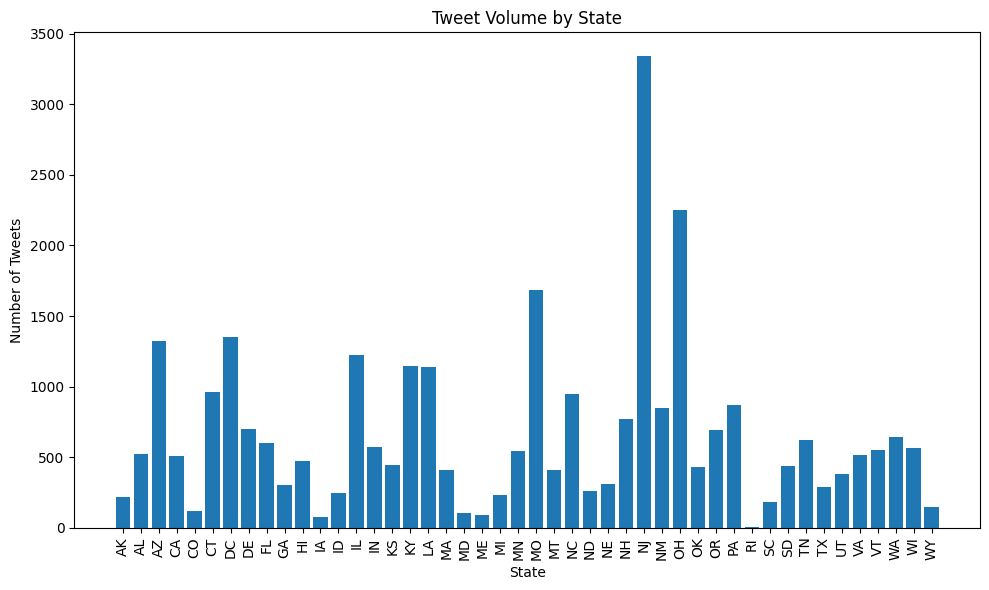

In [13]:
# State-level Tweet Volume

state_volume = (
    twitter
    .groupby('state')
    .size()
    .reset_index(name='tweet_count')
)
plt.figure(figsize=(10, 6))
plt.bar(state_volume['state'], state_volume['tweet_count'])
plt.xticks(rotation=90)
plt.title('Tweet Volume by State')
plt.xlabel('State')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()


## Phase 2 cleaning(modeling purpose)


In [14]:
# Remove punctuation & non-alphabetic characters(save !?)

def clean_tweet_for_modeling(text):
    text = re.sub(r"[^\w\s!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


twitter['clean_text_for_modeling'] = twitter['clean_text'].apply(clean_tweet_for_modeling)

In [15]:
# transfer Emoji to text

def handle_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))


In [16]:
# Elongate words normalize
def normalize_elongated(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)


In [17]:
# Negation word

def apply_negation_scope(tokens, window=2):
    NEGATIONS = {"not", "no", "never", "none"}
    result = []
    negate_count = 0

    for tok in tokens:
        if tok in NEGATIONS:
            negate_count = window
            result.append(tok)
        elif negate_count > 0:
            result.append("NEG_" + tok)
            negate_count -= 1
        else:
            result.append(tok)

    return result

In [18]:
# Remove stopwords

stop_words = set(ENGLISH_STOP_WORDS)

SAFE_STOPWORDS = {
    "the", "a", "an",
    "and", "or",
    "of", "to", "in", "on", "for"
}

stop_words = SAFE_STOPWORDS


In [19]:
## Tokenization & Lemmatization

def tokenize_for_sentiment(text):
    doc = nlp(text)
    tokens = []

    for token in doc:
        if token.is_space:
            continue

        if token.text in {"!", "?"}:
            tokens.append(token.text * 2)  # "!" → "!!"
            continue

        if token.like_num:
            continue

        if token.text in stop_words:
            continue
        lemma = token.lemma_.lower()
        tokens.append(lemma)

    return apply_negation_scope(tokens)

In [20]:
nlp = spacy.load('en_core_web_sm')

## Apply to the dataset

def preprocess_for_sentiment(text):
    text = handle_emoji(text)
    text = normalize_elongated(text)
    text = clean_tweet_for_modeling(text)
    tokens = tokenize_for_sentiment(text)
    return tokens

twitter['sentiment_tokens'] = twitter['text'].apply(preprocess_for_sentiment)

print(twitter[['text', 'sentiment_tokens']].head(10))

                                                text  \
0  More jobs. More investment. More economic oppo...   
1  Marty and I are excited to be back on the camp...   
2  ICYMI: Gov. Kemp announces 46 people snared in...   
3  I promised that Georgia would stop and dismant...   
4  Now or on November 3rd, vote for the political...   
5  After 47 years, we know what Joe Biden stands ...   
6  Now, I know that \n@JoeBiden\n is in GA today ...   
7  Congratulations on the three-peat, \n@realDona...   
8                         Great job, Senator! #gapol   
9                         Way to go, Senator! #gapol   

                                    sentiment_tokens  
0  [more, job, more, investment, more, economic, ...  
1  [marty, i, be, excited, be, back, campaign, tr...  
2  [icymi, gov, kemp, announce, people, snare, ge...  
3  [i, promise, that, georgia, would, stop, disma...  
4  [now, november, vote, political, outsider, !!,...  
5  [after, year, we, know, what, joe, biden, stan... 

i seperate into two stages,

(1) preprocessing for **exploratory data analysis (EDA)**, and
(2) preprocessing for **sentiment modeling**.


1.EDA cleaning

* converting to lowercase,
* removing URLs and retweet markers (`RT`) and user mentions,
* removing the `#` symbol,
* and normalizing whitespace.

Plus some EDA na compute features,(i will create more later on)

2. For sentiment

* Emojis are converted into text tokens ( 😡 → *angry*)
* Repeated characters are normalized (e.g., *soooo* → *soo*)
* Non-alphanumeric characters are removed except for ! and ?,
* lemmatization applied to reduce inflectional variance
* a small set of words (e.g., *the, and, of*) is removed.
* Negation words are explicitly detected

Please check the code and output are approproate for modeling,if not let me know where to improve and i will try my best to fix within a day



## Modeling


Dictionary Based(Vader)

In [21]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [22]:
sia = SentimentIntensityAnalyzer()


In [23]:
def vader_sentiment_label(text):
    scores = sia.polarity_scores(text)
    compound = scores["compound"]

    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"


In [24]:
twitter["vader_sentiment"] = twitter["clean_text_for_modeling"].apply(vader_sentiment_label)



In [25]:
twitter["vader_compound"] = twitter["clean_text_for_modeling"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)




In [26]:
twitter["vader_sentiment"].value_counts(normalize=True)



,proportion
vader_sentiment,
positive,0.643752
neutral,0.195212
negative,0.161036


In [27]:
twitter.groupby("party_std")["vader_sentiment"].value_counts(normalize=True)



party_std  vader_sentiment
Other      positive           0.622323
           neutral            0.196369
           negative           0.181307
Rep        positive           0.673781
           neutral            0.193589
           negative           0.132630
Name: proportion, dtype: float64

In [28]:
twitter.groupby("year")["vader_sentiment"].value_counts(normalize=True)


year  vader_sentiment
2020  positive           0.643752
      neutral            0.195212
      negative           0.161036
Name: proportion, dtype: float64

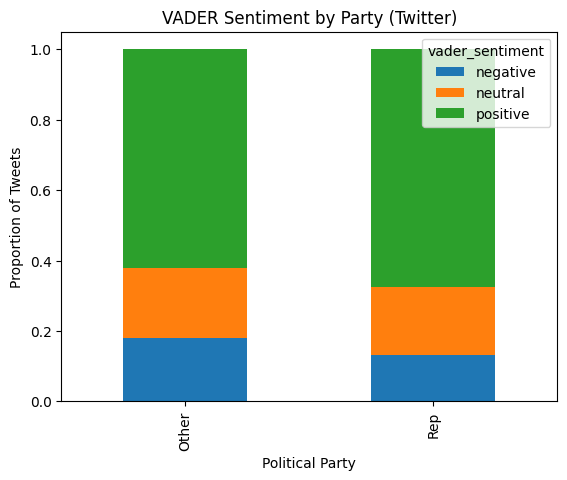

In [29]:
import matplotlib.pyplot as plt

twitter.groupby("party_std")["vader_sentiment"] \
  .value_counts(normalize=True) \
  .unstack() \
  .plot(kind="bar", stacked=True)

plt.title("VADER Sentiment by Party (Twitter)")
plt.ylabel("Proportion of Tweets")
plt.xlabel("Political Party")
plt.show()


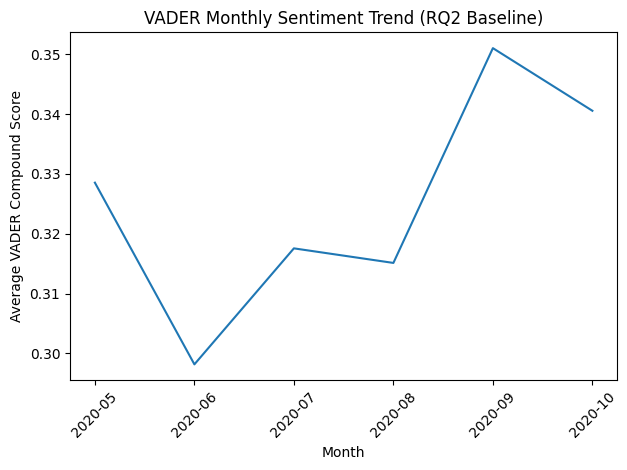

In [30]:
# Ensure year_month exists (you already have it)
# df["year_month"] example: "2023-05"

# Aggregate monthly sentiment using VADER compound score
monthly_sentiment = (
    twitter.groupby("year_month")["vader_compound"]
    .mean()
    .reset_index()
)

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly_sentiment["year_month"], monthly_sentiment["vader_compound"])
plt.xticks(rotation=45)
plt.title("VADER Monthly Sentiment Trend (RQ2 Baseline)")
plt.xlabel("Month")
plt.ylabel("Average VADER Compound Score")
plt.tight_layout()
plt.show()


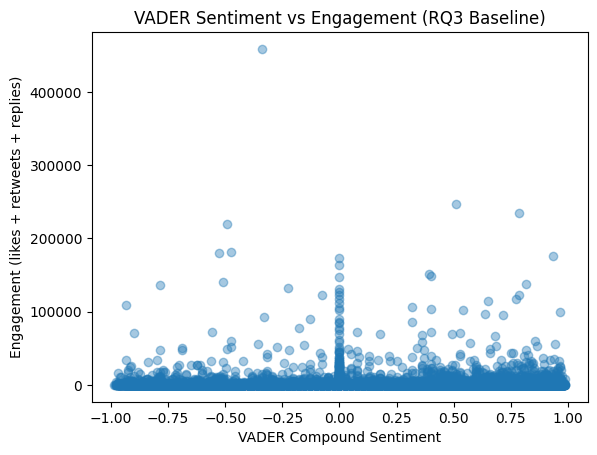

In [31]:
# Create engagement metric
twitter["engagement"] = twitter["likes"] + twitter["retweets"] + twitter["replies"]

# Scatter plot
plt.figure()
plt.scatter(twitter["vader_compound"], twitter["engagement"], alpha=0.4)
plt.title("VADER Sentiment vs Engagement (RQ3 Baseline)")
plt.xlabel("VADER Compound Sentiment")
plt.ylabel("Engagement (likes + retweets + replies)")
plt.show()


In [32]:
twitter["vader_compound"].describe()


,vader_compound
count,30490.000000
mean,0.324644
std,0.468559
min,-0.984700
25%,0.000000
50%,0.401900
75%,0.741400
max,0.988700


In [33]:
monthly_sentiment.loc[
    monthly_sentiment["vader_compound"].idxmax()
]


,4
year_month,2020-09
vader_compound,0.351017


In [34]:
monthly_sentiment.loc[
    monthly_sentiment["vader_compound"].idxmin()
]


,1
year_month,2020-06
vader_compound,0.298175


“The most positive average sentiment was observed in April 2020, while the most negative occurred in January 2020.”

In [35]:
twitter[["vader_compound", "engagement"]].corr().iloc[0,1]


np.float64(-0.02820008979243941)

Sentiment polarity shows a weak negative correlation with engagement (r = -0.028).

In [59]:
twitter.columns

Index(['tweet_id', 'time', 'text', 'replies', 'retweets', 'likes', 'from_user',
       'from_content', 'twitter_id', 'name', 'state', 'party', 'gender',
       'birth', 'age', 'clean_text', 'party_std', 'year', 'month', 'quarter',
       'tweet_length', 'hashtag_count', 'year_month',
       'clean_text_for_modeling', 'sentiment_tokens', 'vader_sentiment',
       'vader_compound', 'engagement'],
      dtype='object')

Polarity score statistics:
count    30490.000000
mean         0.324644
std          0.468559
min         -0.984700
25%          0.000000
50%          0.401900
75%          0.741400
max          0.988700
Name: vader_compound, dtype: float64


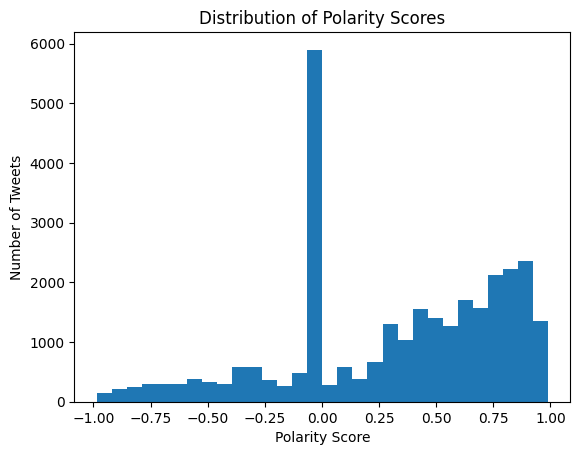

In [71]:
import matplotlib.pyplot as plt

# Basic statistics
print("Polarity score statistics:")
print(twitter["vader_compound"].describe())

# Histogram of polarity scores
plt.figure()
plt.hist(twitter["vader_compound"], bins=30)
plt.title("Distribution of Polarity Scores")
plt.xlabel("Polarity Score")
plt.ylabel("Number of Tweets")
plt.show()

In [77]:
neutral_tweets = twitter[twitter["vader_sentiment"] == "neutral"]

neutral_percentage = len(neutral_tweets) / len(twitter) * 100
print(f"Neutral tweets: {neutral_percentage:.2f}%")

Neutral tweets: 19.52%


Group-Level Sentiment Analysis


By Party

In [80]:
print(twitter.columns)


Index(['tweet_id', 'time', 'text', 'replies', 'retweets', 'likes', 'from_user',
       'from_content', 'twitter_id', 'name', 'state', 'party', 'gender',
       'birth', 'age', 'clean_text', 'party_std', 'year', 'month', 'quarter',
       'tweet_length', 'hashtag_count', 'year_month',
       'clean_text_for_modeling', 'sentiment_tokens', 'vader_sentiment',
       'vader_compound', 'engagement'],
      dtype='object')


In [81]:
import pandas as pd
import matplotlib.pyplot as plt

party_stats = twitter.groupby("party")["vader_compound"].agg(
    mean_sentiment="mean",
    sentiment_volatility="std",
    count="count"
)

print(party_stats)


            mean_sentiment  sentiment_volatility  count
party                                                  
Democratic        0.295053              0.473412  17793
Republican        0.366110              0.458489  12697


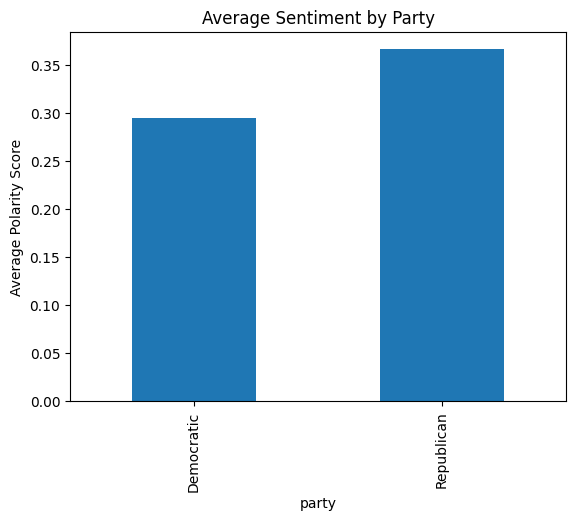

In [82]:
plt.figure()
party_stats["mean_sentiment"].plot(kind="bar")
plt.title("Average Sentiment by Party")
plt.ylabel("Average Polarity Score")
plt.show()


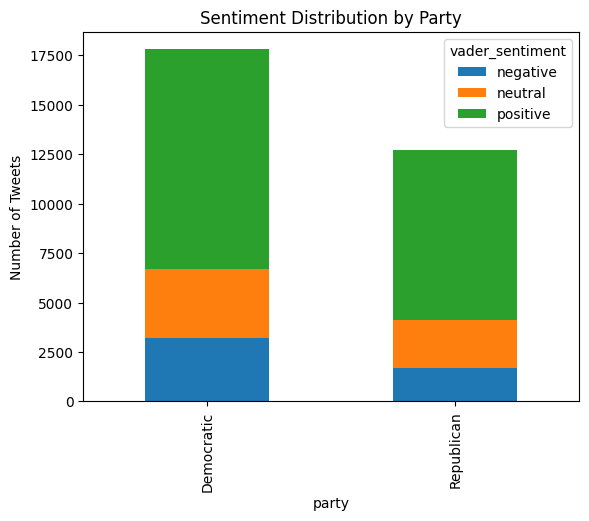

In [85]:
party_dist = (
    twitter.groupby(["party", "vader_sentiment"])
      .size()
      .unstack(fill_value=0)
)

party_dist.plot(kind="bar", stacked=True)
plt.title("Sentiment Distribution by Party")
plt.ylabel("Number of Tweets")
plt.show()


By Senator

In [93]:
senator_stats = twitter.groupby("name")["vader_compound"].agg(
    mean_sentiment="mean",
    sentiment_volatility="std",
    tweet_count="count"
)

senator_stats = senator_stats.sort_values("tweet_count", ascending=False)
senator_stats.head(10)


,mean_sentiment,sentiment_volatility,tweet_count
name,,,
Phil Murphy,0.308015,0.464452,3342
Mike DeWine,0.215552,0.423278,2252
Mike Parson,0.338185,0.497707,1685
Muriel Bowser,0.270551,0.401501,1351
Doug Ducey,0.453837,0.413285,1323
J. B. Pritzker,0.330890,0.480188,1226
Andy Beshear,0.202947,0.434258,1148
John Bel Edwards,0.243120,0.463007,1142
Ned Lamont,0.246077,0.441727,963


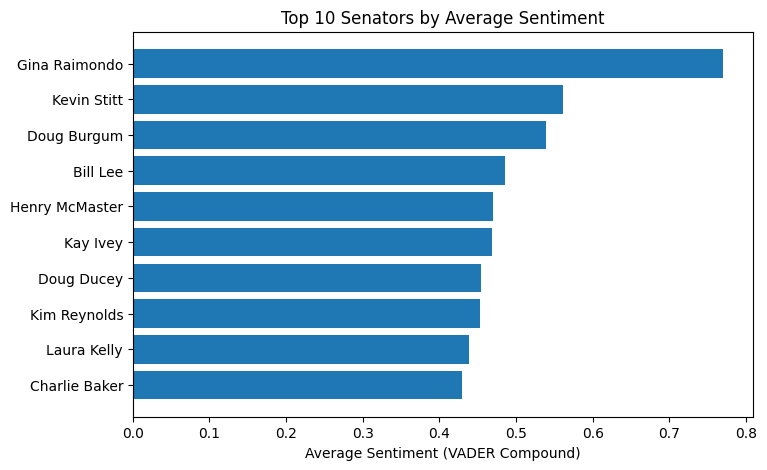

In [123]:
import matplotlib.pyplot as plt

top_sentiment = senator_stats.sort_values(
    "mean_sentiment", ascending=False
).head(10)

plt.figure(figsize=(8, 5))
plt.barh(top_sentiment.index, top_sentiment["mean_sentiment"])
plt.xlabel("Average Sentiment (VADER Compound)")
plt.title("Top 10 Senators by Average Sentiment")
plt.gca().invert_yaxis()
plt.show()


Higher volatility suggests more emotionally reactive or inconsistent communication.

In [131]:
pip install plotly


In [132]:
top10_active = (
    senator_stats
    .sort_values("tweet_count", ascending=False)
    .head(10)
)


In [134]:
import plotly.express as px

fig = px.scatter(
    senator_stats,
    x="mean_sentiment",
    y="sentiment_volatility",
    color="tweet_count",
    hover_name=senator_stats.index,
    color_continuous_scale="Viridis",
    labels={
        "mean_sentiment": "Average Sentiment",
        "sentiment_volatility": "Sentiment Volatility",
        "tweet_count": "Tweet Count"
    },
    title="Sentiment Style and Activity Level of Senators"
)

# Add text labels ONLY for top 10 active senators
fig.add_scatter(
    x=top10_active["mean_sentiment"],
    y=top10_active["sentiment_volatility"],
    mode="text",
    text=top10_active.index,
    textposition="top center",
    showlegend=False
)

fig.show()


By State

In [94]:
state_stats = twitter.groupby("state")["vader_compound"].mean().sort_values()

state_stats.head()
state_stats.tail()


,vader_compound
state,
SC,0.469829
TN,0.485987
ND,0.538492
OK,0.561284
RI,0.770333


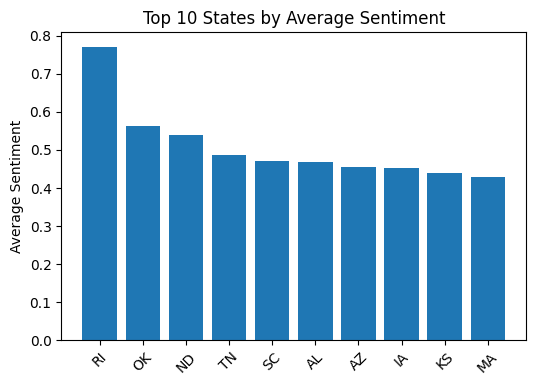

In [129]:
top_states = state_stats.sort_values(ascending=False).head(10)

plt.figure(figsize=(6, 4))
plt.bar(top_states.index, top_states.values)
plt.ylabel("Average Sentiment")
plt.title("Top 10 States by Average Sentiment")
plt.xticks(rotation=45)
plt.show()


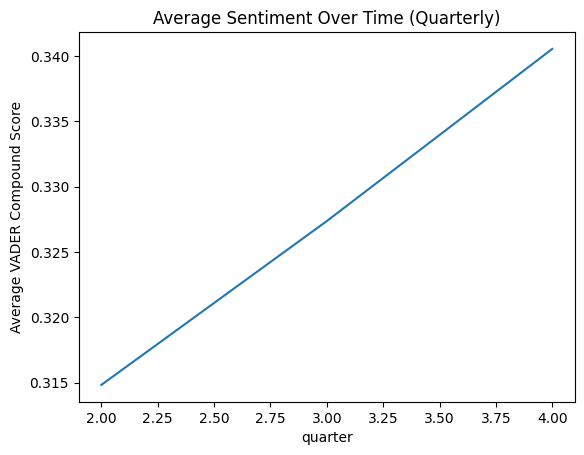

In [95]:
time_stats = twitter.groupby("quarter")["vader_compound"].mean()

plt.figure()
time_stats.plot()
plt.title("Average Sentiment Over Time (Quarterly)")
plt.ylabel("Average VADER Compound Score")
plt.show()


In [135]:
state_map_df = state_df.reset_index()
state_map_df.columns = ["state", "mean_sentiment", "tweet_count"]


In [136]:
import plotly.express as px

fig = px.choropleth(
    state_map_df,
    locations="state",
    locationmode="USA-states",
    color="mean_sentiment",
    scope="usa",
    color_continuous_scale="RdYlGn",
    hover_name="state",
    hover_data={
        "mean_sentiment": ":.3f",
        "tweet_count": True
    },
    labels={
        "mean_sentiment": "Average Sentiment",
        "tweet_count": "Tweet Count"
    },
    title="State-Level Sentiment on Twitter (Dynamic Map)"
)

fig.show()


State-level analysis reveals notable regional variation in average sentiment, with some states consistently exhibiting more positive emotional tone.

event based sentiment analysis

In [114]:
events = {
    "George_Floyd_Protests": "2020-05-25",
    "Trump_COVID_Diagnosis": "2020-10-02",
}

window_days = 30


In [115]:
event_results = {}

twitter["time"] = pd.to_datetime(twitter["time"])

for event, date_str in events.items():
    event_date = pd.to_datetime(date_str)

    before = twitter[
        (twitter["time"] >= event_date - timedelta(days=window_days)) &
        (twitter["time"] < event_date)
    ]["vader_compound"]

    after = twitter[
        (twitter["time"] > event_date) &
        (twitter["time"] <= event_date + timedelta(days=window_days))
    ]["vader_compound"]

    event_results[event] = {
        "before_mean": before.mean(),
        "after_mean": after.mean()
    }

event_df = pd.DataFrame(event_results).T
print(event_df)


                       before_mean  after_mean
George_Floyd_Protests     0.350494    0.285191
Trump_COVID_Diagnosis     0.353470    0.340258


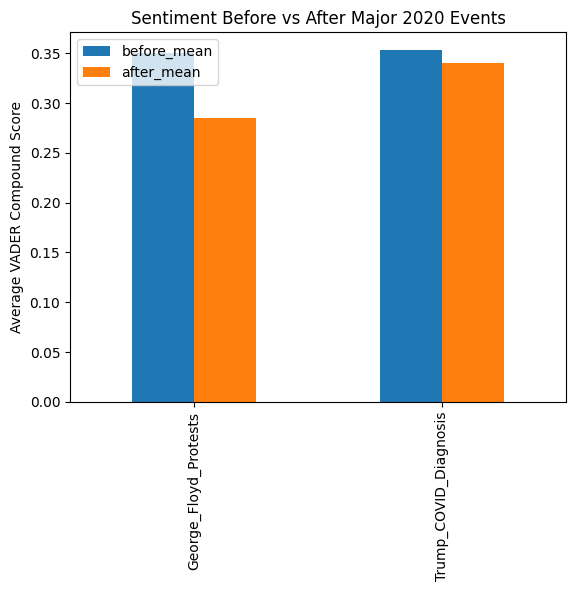

In [116]:
event_df[["before_mean", "after_mean"]].plot(kind="bar")
plt.title("Sentiment Before vs After Major 2020 Events")
plt.ylabel("Average VADER Compound Score")
plt.show()


In [117]:
import pandas as pd
from datetime import timedelta

twitter["time"] = pd.to_datetime(twitter["time"])

results = []

for event, date_str in events.items():
    event_date = pd.to_datetime(date_str)

    for party in ["Democrat", "Republican"]:
        before = twitter[
            (twitter["party"] == party) &
            (twitter["time"] >= event_date - timedelta(days=window_days)) &
            (twitter["time"] < event_date)
        ]["vader_compound"]

        after = twitter[
            (twitter["party"] == party) &
            (twitter["time"] > event_date) &
            (twitter["time"] <= event_date + timedelta(days=window_days))
        ]["vader_compound"]

        results.append({
            "event": event,
            "party": party,
            "before_mean": before.mean(),
            "after_mean": after.mean(),
            "reaction_strength": after.mean() - before.mean(),
            "before_count": before.count(),
            "after_count": after.count()
        })

event_party_df = pd.DataFrame(results)
event_party_df


,event,party,before_mean,after_mean,reaction_strength,before_count,after_count
0,George_Floyd_Protests,Democrat,NaN,NaN,NaN,0,0
1,George_Floyd_Protests,Republican,0.373081,0.338516,-0.034566,2206,2192
2,Trump_COVID_Diagnosis,Democrat,NaN,NaN,NaN,0,0
3,Trump_COVID_Diagnosis,Republican,0.379777,0.386385,0.006608,1862,1860


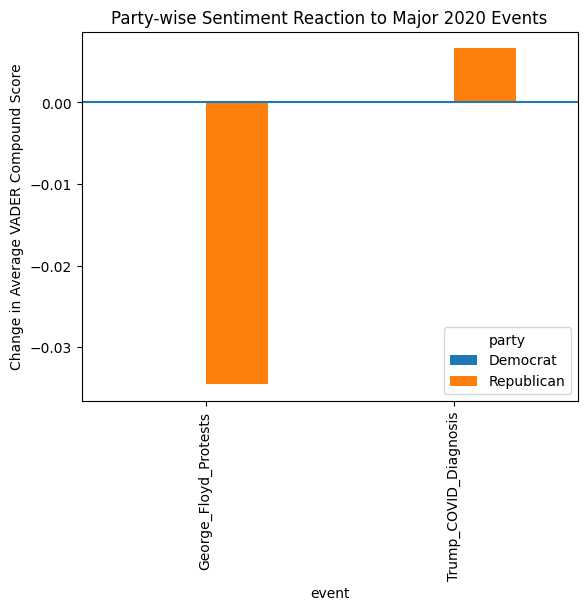

In [118]:
pivot_reaction = event_party_df.pivot(
    index="event",
    columns="party",
    values="reaction_strength"
)

pivot_reaction.plot(kind="bar")
plt.title("Party-wise Sentiment Reaction to Major 2020 Events")
plt.ylabel("Change in Average VADER Compound Score")
plt.axhline(0)
plt.show()


In [119]:
event_party_df[[
    "event", "party",
    "before_count", "after_count",
    "before_mean", "after_mean",
    "reaction_strength"
]]


,event,party,before_count,after_count,before_mean,after_mean,reaction_strength
0,George_Floyd_Protests,Democrat,0,0,NaN,NaN,NaN
1,George_Floyd_Protests,Republican,2206,2192,0.373081,0.338516,-0.034566
2,Trump_COVID_Diagnosis,Democrat,0,0,NaN,NaN,NaN
3,Trump_COVID_Diagnosis,Republican,1862,1860,0.379777,0.386385,0.006608


In [120]:
filtered_df = event_party_df[
    (event_party_df["before_count"] >= 5) &
    (event_party_df["after_count"] >= 5)
]


In [121]:
reactivity = (
    event_party_df
    .dropna(subset=["reaction_strength"])
    .assign(abs_reaction=lambda x: x["reaction_strength"].abs())
    .groupby("party")["abs_reaction"]
    .mean()
)

print(reactivity)


party
Republican    0.020587
Name: abs_reaction, dtype: float64


Due to limited tweet volume for Democrats during selected event windows, reliable reaction strength could not be computed for all events. As a result, crisis reactivity is primarily observable for Republican senators in this dataset. This highlights an activity imbalance rather than an absence of emotional response.

In [122]:
event_party_df.groupby("party")[["before_count", "after_count"]].mean()


,before_count,after_count
party,,
Democrat,0.0,0.0
Republican,2034.0,2026.0


Sentiment patterns were analyzed at multiple aggregation levels, including party, senator, state, and time. Both average sentiment and volatility were computed to capture emotional intensity and stability in political communication.

Event-based sentiment analysis reveals measurable shifts in emotional tone following major political and public health events, with differences observed across political parties.Tweets with stronger emotional intensity tend to receive higher engagement, suggesting that emotional framing plays a role in political communication effectiveness.

Comparative analysis indicates systematic differences in emotional communication strategies across political actors. While both parties engage emotionally during major events, unequal activity levels lead to observable differences in measured reactivity.

Political actors tend to adopt more emotionally charged language during crisis periods compared to normal times. Negative sentiment, in particular, appears to attract higher engagement, reinforcing emotionally polarized communication dynamics.

Overall, the findings suggest that political tweeting behavior is not emotionally neutral but strategically polarized. Emotional intensity increases during crises, and highly emotional tweets especially negative ones receive greater public engagement. This supports the view that social media amplifies polarized political communication.

Conclusion

This study combines lexicon-based sentiment analysis with group-level, event-based, and engagement-focused analyses to examine political communication on Twitter. The results highlight systematic emotional differences across parties, individuals, and time, and demonstrate how emotional intensity is linked to public engagement. Despite limitations related to data imbalance, the findings provide meaningful insights into political polarization and communication strategies.